# Text Classification with Tensorflow 2
###### Adapted from Rich Folsom's article:
###### https://towardsdatascience.com/tensorflow-2-0-data-transformation-for-text-classification-b86ee2ad8877

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import joblib
vocabul_size = 8000
SEQ_LEN = 256
EMBEDDING_DIM = 16
BATCH_SIZE = 16
EPOCHS = 20

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix  #Required input to plot_confusion_matrix
import seaborn as sns

# Inspired by Shay Palachy's function:  https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def plot_confusion_matrix(confusion_matrix, class_names, errors_only=False, figsize = (15,6), fontsize=16):
    """
    Plots confusion matrix as a color-encoded Seaborn heatmap.  Zeroes are
    colored white.  Normalized values that are zero when rounded to three
    decimals, Ex. 0.000, will be colored white.  Get more decicmals by
    updating fmt, for example to '0.4f', and updating get_text() value.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object sklearn.metrics.confusion_matrix. 
    class_names: list
        List of class names in the order they index the confusion matrix.
    figsize: tuple
        A pair tuple.  The first value is figure width.  The second
        value is figure height. Defaults to (15,6).
    fontsize: int
        Font size for axes labels. Defaults to 16.
    """        
    #Instantiate Figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plt.subplots_adjust(wspace = 0.5)
    
    #Show errors only by filling diagonal with zeroes.
    if errors_only:
        np.fill_diagonal(confusion_matrix, 0)        
        
    # ax1 - Normalized Confusion Matrix    
    #Normalize by dividing (M X M) matrix by (M X 1) matrix.  (M X 1) is row totals.
    conf_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:,np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)  #fix any nans caused by zero row total
    df_cm_norm = pd.DataFrame(conf_matrix_norm, index=class_names, columns=class_names)
    heatmap = sns.heatmap(df_cm_norm, ax=ax1, cmap='Blues', fmt='.3f', annot=True, annot_kws={"size": fontsize},
              linewidths=2, linecolor='black', cbar=False)
    
    ax1.tick_params(axis='x', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax1.tick_params(axis='y', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax1.set_ylim(ax1.get_xlim()[0], ax1.get_xlim()[1])  #Fix messed up ylim
    ax1.set_xlabel('PREDICTED CLASS', fontsize=fontsize, color='black')
    ax1.set_ylabel('TRUE CLASS', fontsize=fontsize, color='black')
    ax1.set_title('Confusion Matrix - Normalized', pad=15, fontsize=fontsize, color='black')
    
    # ax2 - Confusion Matrix - Class Counts
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)    
    heatmap = sns.heatmap(df_cm, ax=ax2, cmap='Blues', fmt='d', annot=True, annot_kws={"size": fontsize},
              linewidths=2, linecolor='black', cbar=False)   
    
    ax2.tick_params(axis='x', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax2.tick_params(axis='y', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax2.set_ylim(ax1.get_xlim()[0], ax1.get_xlim()[1])  #Fix bug in matplotlib 3.1.1.  Or, use earlier matplotlib.
    ax2.set_xlabel('PREDICTED CLASS', fontsize=fontsize, color='black')
    ax2.set_ylabel('TRUE CLASS', fontsize=fontsize, color='black')
    ax2.set_title('Confusion Matrix - Class Counts', pad=15, fontsize=fontsize, color='black')    
  
    for text in ax1.texts:
        if text.get_text() == '0.000':
            text.set_color(color='white')            
    for text in ax2.texts:
        if text.get_text() == '0':
            text.set_color(color='white')

In [3]:
import pandas as pd
import os

def build_df(start_path):
    '''
    Append all files in the target folder.  Then return as dataframe.
    '''

    df = pd.DataFrame(columns=['review', 'sentim'])
    review = []
    sentim = []
    
    for folder in ['neg','pos']:
        fpath=os.path.join(start_path, folder)
        files = [f for f in os.listdir(fpath)]
        
        for f in files:
            with open(os.path.join(fpath, f), "r", encoding='utf8') as myfile:
                # replace linefeed (\n) and carriage return (\r) with space
                review.append(myfile.read().replace("\n", " ").replace("\r", " "))
                # convert positive reviews to 1 and negative reviews to zero
                sentim.append(1 if folder == 'pos' else 0)

    df['review']=review
    df['sentim']=sentim
    #This line shuffles the data so you don't end with contiguous
    #blocks of positive and negative reviews
    df = df.sample(frac=1).reset_index(drop=True)      
    return df

#double backslash for Windows
train_df = build_df('aclImdb\\train')
test_df = build_df("aclImdb\\test")

In [5]:
#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocabul_size, oov_token='<UNK>')
tokenizer.fit_on_texts(train_df['review'])

In [6]:
print("length of word index dictionary:", len(tokenizer.word_index))

length of word index dictionary: 88581


In [7]:
#tokenizer.word_index

In [8]:
#convert text data to sequence of integers
train_seqs=tokenizer.texts_to_sequences(train_df['review'])
test_seqs=tokenizer.texts_to_sequences(test_df['review'])

In [9]:
#Use exactly 256 words per review by padding or truncating.
train_seqs=tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=SEQ_LEN, padding="post")
test_seqs=tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=SEQ_LEN, padding="post")

In [10]:
print('train_seqs:', train_seqs.shape)
print('test_seqs:', test_seqs.shape)

train_seqs: (25000, 256)
test_seqs: (25000, 256)


In [12]:
#Fit TensorFlow 2 model

#Embedding: The vocabul_size is the input_dim. EMBEDDING_DIM is the embedding dimensions.
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocabul_size, EMBEDDING_DIM),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')
callbacks=[es]
history = model.fit(train_seqs, train_df['sentim'].values
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_split=0.2
                    , callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 128,017
Trainable params: 128,017
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 6s 277us/sample - loss: 0.6198 - accuracy: 0.7349 - val_loss: 0.5099 - val_accuracy: 0.8226
Epoch 2/20
20000/20000 [==============================] - 5s 248us/sample - loss: 0.4250 - accuracy: 0.8508 - val_loss: 0.3771 - val_accuracy: 0.8642
Epoch 3/20
20000/20000 [=====

In [13]:
#Evaluate model on test data
model.evaluate(test_seqs, test_df['sentim'].values)

25000/25000 [==============================] - 2s 69us/sample - loss: 0.2850 - accuracy: 0.8822


[0.28496613451957703, 0.88224]

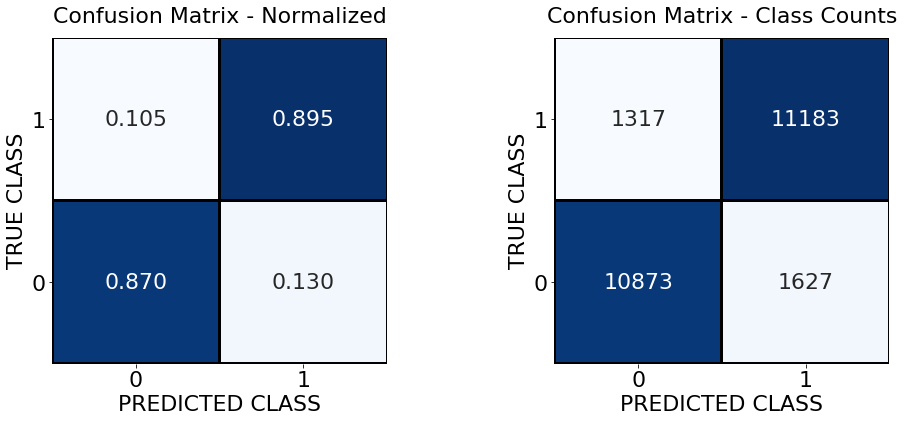

In [14]:
#Get prediction in probability format.  Convert to binary.
test_preds = model.predict(test_seqs)
test_pred_ints = [int(i>0.5) for i in test_preds]

#Compute confusion matrix: confusion_matrix(y_true, y_pred)
class_labels = [0,1]
cm=confusion_matrix(test_df['sentim'].values, test_pred_ints, labels=class_labels)
plot_confusion_matrix(confusion_matrix=cm, class_names=class_labels, fontsize=22)

In [15]:
#Save model and tokenizer.  Delete model and tokenizer.
model.save('model.h5')
joblib.dump(tokenizer, 'tokenizer.joblib', compress=1)

del model
del tokenizer